In [2]:
#step 1 import image
%matplotlib inline
import torchvision.datasets
import math
import torchvision.transforms as tvt
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import wget
import zipfile
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as tfms
from torch.utils.data import DataLoader, Subset, Dataset
from torchvision.utils import make_grid
from PIL import Image
from time import time
from tqdm import tqdm
from transformers import ViTConfig, ViTModel

device = torch.device('cuda:2')
image_size = 64
batch_size = 256
dataset = torchvision.datasets.CelebA("../celeba/datasets/",split='train', transform=tvt.Compose([
                                  tvt.Resize((image_size,image_size)),
                                  tvt.ToTensor(),
                                  tvt.Normalize(mean=[0.5, 0.5, 0.5],
                                                std=[0.5, 0.5, 0.5])
                              ]))

test_dataset = torchvision.datasets.CelebA("../celeba/datasets/",split='test', transform=tvt.Compose([
                                  tvt.Resize((image_size,image_size)),
                                  tvt.ToTensor(),
                                  tvt.Normalize(mean=[0.5, 0.5, 0.5],
                                                std=[0.5, 0.5, 0.5])
                              ]))

training_data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=False)
print('Done')

/home/shenyu/miniconda3/envs/DLcourse/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Done


In [3]:
from transformers import ViTConfig, ViTModel
configuration = ViTConfig(num_hidden_layers = 8, num_attention_heads = 8, 
                          intermediate_size = 256, image_size= 64, patch_size = 16)
model = ViTModel(configuration)
configuration = model.config
t = iter(test_data_loader)
img, label = next(t)
img
y = model(img)
y.last_hidden_state.shape

torch.Size([256, 17, 768])

In [4]:
def choose_value_patch(atten, value, p_dim):
    # input insturction: 
    # atten: shape: Batch, Head, Patch
    # value: Batch, Head, Patch, Dim
    # Output: Batch, Head, Selct_Patch, dim
    atten = atten[:,:,1:]
    top_k_values, top_k_indices = torch.topk(atten, k=p_dim, dim=2, sorted=False)
    #top_k_indices : Batch, Head, Select_patch
    output = torch.gather(value, 2, top_k_indices.unsqueeze(-1).expand(-1,-1,-1,value.size(-1)))
    return output
    
class Last_Attention(nn.Module):
    def __init__(self):
        super(Last_Attention, self).__init__()
        self.emb_size = 256
        self.head = 8
        self.temperature = 1
        self.head_dim = self.emb_size //self.head
        self.Q = nn.Linear(256,256)
        self.K = nn.Linear(256,256)
        self.V = nn.Linear(256,256)
        self.projection = nn.Linear(256, 256)
        self.soft_max = nn.Softmax(dim=-1)
        
    def forward(self, x, training=True):
        B, N, C = x.shape
        origin_q = self.Q(x)
        origin_k = self.K(x)
        origin_v = self.V(x)
        q = origin_q.reshape(B,N,self.head, C//self.head).permute(0,2,1,3)
        k = origin_k.reshape(B,N,self.head, C//self.head).permute(0,2,1,3)
        v = origin_v.reshape(B,N,self.head, C//self.head).permute(0,2,1,3)
        attention = (q @ k.transpose(-2,-1))* (self.head_dim ** (-0.5))    
        atten = self.soft_max(attention/self.temperature)
        out = (atten @ v).transpose(1, 2).reshape(B, N, C)
        out = self.projection(out)
        return out, origin_q, origin_k

   

    
class Last_ATBlock(nn.Module):
    def __init__(self):
        super().__init__()
        dim = 256
        self.norm = nn.LayerNorm(dim)
        self.attention = Last_Attention()
        self.norm2 = nn.LayerNorm(dim)
        self.feedforward = nn.Sequential(
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 256)          
        )
        
    def forward(self, x, training=True):
        identity = x
        x = self.norm(x)
        x, q, k = self.attention(x, training)
        x += identity
        res = x 
        x = self.norm2(x)
        x = self.feedforward(x)
        x += res
        return x, q, k

In [5]:
class VisionTransformer(nn.Module):
    def __init__(self, vit):
        super(VisionTransformer, self).__init__()
        self.vit = vit
        self.last_encoder = Last_ATBlock()
        self.seq = nn.Sequential(
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 1),     
            nn.Sigmoid()
        )
    
    def forward(self, x, training=True):
        z = self.vit(x)
        m = z.last_hidden_state
        m, q, k = self.last_encoder(m, training)
        g = m[:,0]
        y = self.seq(g)
        return y, q, k

In [ ]:
import random
import numpy as np
import torch
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_score
from sklearn.metrics import confusion_matrix
from collections import OrderedDict
import seaborn as sns

def seed_everything(seed):
    """
    Changes the seed for reproducibility. 
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    

    

def train_model():
    configuration = ViTConfig(hidden_size = 256, num_hidden_layers = 7, num_attention_heads = 8, 
                          intermediate_size = 256, image_size= 64, patch_size = 16)
    vit = ViTModel(configuration)
    configuration = vit.config
    vit = vit.to(device)
    model = VisionTransformer(vit)
    model = model.to(device)
    
    epoch = 12
    criterion = nn.BCELoss()
    optimizer = optim.AdamW(model.parameters(), lr=1e-4)
    acc = 0
    
    for epoches in range(epoch):
        with tqdm(training_data_loader, unit="batch") as tepoch:
            model.train()
            for train_input, attributes in tepoch:
                # Transfer data to GPU if possible. 
                train_input = train_input.to(device)
                sensitive, train_target = attributes[:,20], attributes[:,2]
                train_target = train_target.float().to(device)
                optimizer.zero_grad()

                # Learner update step.
                #if fairness processorigin_v
                outputs, _, _ = model(train_input)
                train_target = train_target.unsqueeze(1)
                loss = criterion(outputs, train_target)
                tepoch.set_postfix(ul = loss.item())  
                loss.backward()
                optimizer.step()
                tepoch.set_description(f"epoch %2f " % epoches)
                

        model.eval()
        test_pred = []
        test_gt = []
        sense_gt = []
        female_predic = []
        female_gt = []
        male_predic = []
        male_gt = []


    # Evaluate on test set.
        for step, (test_input, attributes) in enumerate(test_data_loader):
            sensitive, test_target = attributes[:,20], attributes[:,2]
            test_input = test_input.to(device)
            test_target = test_target.to(device)

            gt = test_target.detach().cpu().numpy()
            sen = sensitive.detach().cpu().numpy()
            test_gt.extend(gt)
            sense_gt.extend(sen)

            with torch.no_grad():
                test_pred_, _ , _= model(test_input, False)
                test_pred.extend(torch.round(test_pred_.squeeze(1)).detach().cpu().numpy())

        for i in range(len(sense_gt)):
            if sense_gt[i] == 0:
                female_predic.append(test_pred[i])
                female_gt.append(test_gt[i])
            else:
                male_predic.append(test_pred[i])
                male_gt.append(test_gt[i])
        female_CM = confusion_matrix(female_gt, female_predic)    
        male_CM = confusion_matrix(male_gt, male_predic) 
        female_dp = (female_CM[1][1]+female_CM[0][1])/(female_CM[0][0]+female_CM[0][1]+female_CM[1][0]+female_CM[1][1])
        male_dp = (male_CM[1][1]+male_CM[0][1])/(male_CM[0][0]+male_CM[0][1]+male_CM[1][0]+male_CM[1][1])
        female_TPR = female_CM[1][1]/(female_CM[1][1]+female_CM[1][0])
        male_TPR = male_CM[1][1]/(male_CM[1][1]+male_CM[1][0])
        female_FPR = female_CM[0][1]/(female_CM[0][1]+female_CM[0][0])
        male_FPR = male_CM[0][1]/(male_CM[0][1]+male_CM[0][0])
        test_acc = accuracy_score(test_gt, test_pred)
        print('Female TPR', female_TPR)
        print('male TPR', male_TPR)
        print('DP',abs(female_dp - male_dp))
        print('EOP', abs(female_TPR - male_TPR))
        print('EoD',0.5*(abs(female_FPR-male_FPR)+ abs(female_TPR-male_TPR)))
        print('acc', accuracy_score(test_gt, test_pred))

        if test_acc > acc:
            torch.save(model.state_dict(), 'acc_model_state_dict.pth')#save
            acc = test_acc
            print('Saved')
        
        

seed_everything(4096)    
train_model()


In [17]:
configuration = ViTConfig(hidden_size = 256, num_hidden_layers = 7, num_attention_heads = 8, 
                      intermediate_size = 256, image_size= 64, patch_size = 16)
vit = ViTModel(configuration)
configuration = vit.config
vit = vit.to(device)
model = VisionTransformer(vit)
model = model.to(device)
model.load_state_dict(torch.load('acc_model_state_dict.pth', map_location=torch.device('cpu')))



model.eval()
q_female = []
q_male = []
k_female = []
k_male = []

q_y_0 = []
q_y_1 = []
k_y_0 = []
k_y_1 = []

q_list = []
k_list = []
sense_gt = []
label_gt = []
i = 0


# Evaluate on test set.
for step, (test_input, attributes) in enumerate(test_data_loader):
    sensitive, test_target = attributes[:,20], attributes[:,2]
    test_input = test_input.to(device)
    test_target = test_target.to(device)
    tar = test_target.detach().cpu().numpy()
    sen = sensitive.detach().cpu().numpy()
    sense_gt.extend(sen)
    label_gt.extend(tar)

    with torch.no_grad():
        test_pred_, q , k= model(test_input, False)
        q_list.extend(q.detach().cpu().numpy())
        k_list.extend(k.detach().cpu().numpy())
        #i+=1
        #if i > 10:
        #    break
            
for i in range(len(sense_gt)): #target
    if sense_gt[i] == 0:
        q_female.append(q_list[i])
        k_female.append(k_list[i])
    else:
        q_male.append(q_list[i])
        k_male.append(k_list[i])
        
        
for i in range(len(sense_gt)): #target
    if label_gt[i] == 0:
        q_y_0.append(q_list[i])
        k_y_0.append(k_list[i])
    else:
        q_y_1.append(q_list[i])
        k_y_1.append(k_list[i])
        
        
q_female_np = np.array(q_female)
k_female_np = np.array(k_female)
q_male_np = np.array(q_male)
k_male_np = np.array(k_male)

q_y_0_np = np.array(q_y_0)
k_y_0_np = np.array(k_y_0)
q_y_1_np = np.array(q_y_1)
k_y_1_np = np.array(k_y_1)

print(q_female_np.shape)
print(k_female_np.shape)
print(q_male_np.shape)
print(k_male_np.shape)


(12247, 17, 256)
(12247, 17, 256)
(7715, 17, 256)
(7715, 17, 256)
[[[ 1.2846682   2.1666331  -0.06291021 ... -0.34576645  1.2238549
   -0.01474133]
  [ 0.64569473  0.47223538  1.041247   ...  0.9960064   1.7014457
   -1.0216382 ]
  [ 0.37549034  1.2205621   1.1446086  ... -0.32421392  2.1656413
   -0.95462155]
  ...
  [ 1.0209028   1.9864997   0.9503029  ... -0.07576338  2.3797786
   -1.2069778 ]
  [ 0.9874954   1.2143003   1.3467695  ...  0.4522968   1.6049397
   -0.45808524]
  [-0.6480949   0.69980097  0.8360876  ... -0.641094    0.94798064
   -0.6677275 ]]

 [[ 1.0715672   1.1967177   0.20770869 ... -0.68002576  2.3460755
   -0.6082406 ]
  [ 0.7618736   1.2984267   0.6519716  ... -0.57601273  2.0534606
   -0.68185025]
  [-0.62430334 -0.01949869  0.6572688  ... -1.1071367   0.95433927
   -1.0817149 ]
  ...
  [ 1.4941549   1.9750957   0.79141897 ...  0.30000547  2.5719726
   -1.08653   ]
  [ 0.43783703  1.1693085   0.9180992  ... -0.58774376  1.9300293
   -0.74317276]
  [ 0.07049558  

In [43]:
q00 = np.array(q_list)[((np.array(sense_gt) == 0)*(np.array(label_gt) == 0))]
q01 = np.array(q_list)[((np.array(sense_gt) == 0)*(np.array(label_gt) == 1))]
q10 = np.array(q_list)[((np.array(sense_gt) == 1)*(np.array(label_gt) == 0))]
q11 = np.array(q_list)[((np.array(sense_gt) == 1)*(np.array(label_gt) == 1))]
print(q00.shape, q01.shape, q10.shape,q11.shape)

(4263, 17, 256) (7984, 17, 256) (5801, 17, 256) (1914, 17, 256)


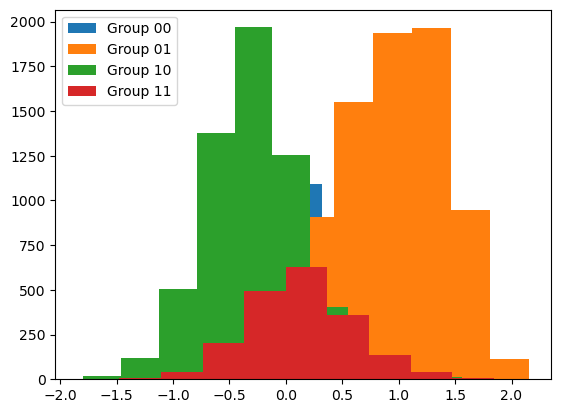

In [53]:
idx = 10
plt.hist(q00[:,0,idx], label='Group 00')
plt.hist(q01[:,0,idx], label='Group 01')
plt.hist(q10[:,0,idx], label='Group 10')
plt.hist(q11[:,0,idx], label='Group 11')
plt.legend()
plt.show()